In [26]:
# Importing the libraries
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import pickle
import os
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

In [27]:
pip install numpy pandas seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
SPLIT_METHOD = 'time'  # 'time' or 'random'
DATA_PATH = "d:\\Desktop\\spring2\\preprocessed_data.csv"  # Adjusted for local path
OUTPUT_DIR = "."
df = pd.read_csv(DATA_PATH)

## Modeling

In [30]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def Calculate_vif(X):
    '''
    Calculating VIF
    '''
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [31]:
Calculate_vif(df[[i for i in df.describe().columns if i not in ['cnt']]])

,variables,VIF
0,season,3.541429
1,yr,1.020251
2,mnth,3.332130
3,holiday,2.284029
4,weekday,1.021463
5,workingday,33.713895
6,weathersit,1.741541
7,temp,1.215589
8,hum,1.905040
9,windspeed,1.165206


workingday	33.7 	Too high → must drop

is_weekend	14.57	High — correlated with workingday

since workingday is the native feature , drop is_weekend ( feature added during feature engineering)

In [32]:
df = df.drop(columns=['is_weekend'])


In [33]:
Calculate_vif(df[[i for i in df.describe().columns if i not in ['cnt']]])

,variables,VIF
0,season,21.112433
1,yr,1.946383
2,mnth,15.229246
3,holiday,1.099314
4,weekday,3.099564
5,workingday,3.267082
6,weathersit,13.070004
7,temp,9.498830
8,hum,25.607610
9,windspeed,5.296247


is_weekend drop definitely helped — workingday (VIF 3.15 ).

But now the time and weather features are highly correlated:

season ↔ mnth

temp ↔ hum

weathersit ↔ temp/hum

In [34]:
# Checking categoiries in season column.
df['season'].value_counts()

season
3    188
2    184
1    181
4    178
Name: count, dtype: int64

In [35]:
season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=True)
df = pd.concat([df, season_dummies], axis=1)
df = df.drop(columns=['season','hum'])


In [36]:
Calculate_vif(df[[i for i in df.describe().columns if i not in ['cnt']]])

,variables,VIF
0,yr,1.946053
1,mnth,4.573376
2,holiday,1.092664
3,weekday,3.085268
4,workingday,3.221616
5,weathersit,6.123932
6,temp,6.701484
7,windspeed,5.251681


The time features (yr, mnth) -fine 

The categorical features (holiday, weekday, workingday) -fine

The weather block (weathersit, temp, windspeed) still carries mild-to-heavy correlation — but acceptable, this is expected and normal for the Bike Sharing dataset.

In [37]:
#standardise continuous features

from sklearn.preprocessing import StandardScaler

num_cols = ['temp', 'windspeed', 'yr']  # numeric columns in final features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


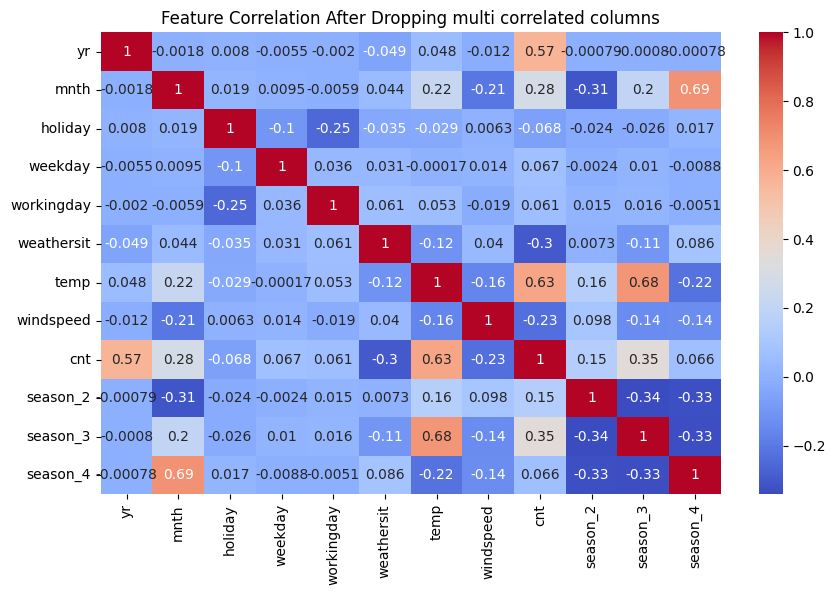

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation After Dropping multi correlated columns")
plt.show()


In [39]:
# Checking categoiries in holiday columns.
df['holiday'].value_counts()

holiday
0    710
1     21
Name: count, dtype: int64

In [40]:
# Checking categoiries in Functioning Day columns.
df['workingday'].value_counts()

workingday
1    500
0    231
Name: count, dtype: int64

In [41]:
df.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,windspeed,cnt,season_2,season_3,season_4
0,-1.001369,1,0,6,0,2,-0.826662,-0.387892,985,False,False,False
1,-1.001369,1,0,0,0,2,-0.721095,0.749602,801,False,False,False
2,-1.001369,1,0,1,1,1,-1.634657,0.746632,1349,False,False,False
3,-1.001369,1,0,2,1,1,-1.614780,-0.389829,1562,False,False,False
4,-1.001369,1,0,3,1,1,-1.467414,-0.046307,1600,False,False,False


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          731 non-null    float64
 1   mnth        731 non-null    int64  
 2   holiday     731 non-null    int64  
 3   weekday     731 non-null    int64  
 4   workingday  731 non-null    int64  
 5   weathersit  731 non-null    int64  
 6   temp        731 non-null    float64
 7   windspeed   731 non-null    float64
 8   cnt         731 non-null    int64  
 9   season_2    731 non-null    bool   
 10  season_3    731 non-null    bool   
 11  season_4    731 non-null    bool   
dtypes: bool(3), float64(3), int64(6)
memory usage: 53.7 KB


### LINEAR REGRESSION

#### 1. Importing necessary libraries

In [43]:
# lets import train test split for splitting the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#### 2. Splitting Train & Test dataset

In [44]:
# Creating a dependent variable for rented bike count
dependent_variable = 'cnt'

In [45]:
# Create a list of independent variables
independent_variables = list(set(df.columns.tolist()) - {dependent_variable})
independent_variables

['windspeed',
 'season_3',
 'weekday',
 'mnth',
 'season_2',
 'yr',
 'season_4',
 'weathersit',
 'workingday',
 'holiday',
 'temp']

In [46]:
# Create the dependent variable data
y = np.sqrt(df['cnt'])

# Create the data of independent variables
X = df.drop('cnt',axis=1)

In [47]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [48]:
X_train[0:10]

,yr,mnth,holiday,weekday,workingday,weathersit,temp,windspeed,season_2,season_3,season_4
97,-1.001369,4,0,5,1,2,-0.872222,0.471378,True,False,False
503,0.998633,5,0,5,1,1,0.376012,-0.692999,True,False,False
642,0.998633,10,0,4,1,2,0.886235,-0.941834,False,False,True
498,0.998633,5,0,0,0,1,0.640234,0.447167,True,False,False
303,-1.001369,10,0,1,1,1,-0.849442,-1.086402,False,False,True
570,0.998633,7,0,2,1,1,1.396458,0.270745,False,True,False
250,-1.001369,9,0,4,1,3,0.757292,0.029205,False,True,False
17,-1.001369,1,0,2,1,2,-1.523666,-0.564417,False,False,False
595,0.998633,8,0,6,0,1,1.000123,-0.162945,False,True,False
240,-1.001369,8,0,1,1,1,0.772347,-0.395910,False,True,False


In [49]:
# Transforming data 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [50]:
# Checking shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(584, 11)
(584,)
(147, 11)
(147,)


In [51]:
X_train[0:10]

array([[0.        , 0.27272727, 0.        , 0.83333333, 1.        ,
        0.5       , 0.35024023, 0.48605788, 1.        , 0.        ,
        0.        ],
       [1.        , 0.36363636, 0.        , 0.83333333, 1.        ,
        0.        , 0.63925722, 0.24873701, 1.        , 0.        ,
        0.        ],
       [1.        , 0.81818182, 0.        , 0.66666667, 1.        ,
        0.5       , 0.75739478, 0.19801995, 0.        , 0.        ,
        1.        ],
       [1.        , 0.36363636, 0.        , 0.        , 0.        ,
        0.        , 0.7004354 , 0.48112329, 1.        , 0.        ,
        0.        ],
       [0.        , 0.81818182, 0.        , 0.16666667, 1.        ,
        0.        , 0.35551467, 0.16855453, 0.        , 0.        ,
        1.        ],
       [1.        , 0.54545455, 0.        , 0.33333333, 1.        ,
        0.        , 0.87553235, 0.44516526, 0.        , 1.        ,
        0.        ],
       [0.        , 0.72727273, 0.        , 0.66666667, 1.

#### 3. Model building with training & testing

In [52]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [53]:
# Cheeck coefficents
regressor.coef_

array([ 15.29868871,  -1.23866693,  -3.87010658,   3.01756277,
         0.95189132, -13.46518336,  32.70987169,  -8.56731923,
         9.1108743 ,   6.86903426,  12.76714928])

In [54]:
pd.DataFrame(regressor.coef_,X.columns, columns=['Coefficient'])

,Coefficient
yr,15.298689
mnth,-1.238667
holiday,-3.870107
weekday,3.017563
workingday,0.951891
weathersit,-13.465183
temp,32.709872
windspeed,-8.567319
season_2,9.110874
season_3,6.869034


In [55]:
# Check intercept
regressor.intercept_

np.float64(36.950710749664566)

In [56]:
# Checking score
regressor.score(X_train,y_train)

0.7972370239148932

In [57]:
# Y peredictions on train data
y_pred_train = regressor.predict(X_train)

# y predictions on test data
y_pred = regressor.predict(X_test)

#### Calculated values insights

Growth over time (yr ↑)

Warm weather boosts demand (temp ↑)

Wind & bad weather kill demand (weathersit, windspeed ↓)

Holidays slightly drop rentals

Working days bring consistent traffic


#### GENERAL INSIGHTS - model training (linear regression)

| **Line / Term**                                                     | **Meaning / Purpose**                                                 | **Why It’s Used**                                                                       | **What Value It Holds**                                                              | **Syntax Explanation**                                                                                                          |
| ------------------------------------------------------------------- | --------------------------------------------------------------------- | --------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------- |
| `LinearRegression()`                                                | Creates a Linear Regression model object from `sklearn.linear_model`. | This object will later be trained (fitted) with the data.                               | It’s an **untrained model** at this point.                                           | `regressor = LinearRegression()` initializes the model with default parameters like `fit_intercept=True`.                       |
| `regressor.fit(X_train, y_train)`                                   | Trains the model on the training data.                                | Finds the **best-fit line** (coefficients + intercept) that minimizes prediction error. | After fitting, the model learns parameters (`coef_` and `intercept_`).               | `fit()` takes in features (X) and target (y) to compute weights.                                                                |
| `regressor.coef_`                                                   | The array of **coefficients** (weights) for each feature.             | Tells how much each feature contributes to the prediction.                              | Each value shows the **strength and direction** of the relationship with the target. | Example: `coef_[0] = 2.5` means for every 1 unit increase in feature 1, target increases by 2.5 units (if others are constant). |
| `pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])` | Converts the coefficients into a table with column names.             | Helps visualize which features have higher/lower influence.                             | A DataFrame showing each feature with its corresponding coefficient.                 | `pd.DataFrame(data, index, columns)` — makes it readable.                                                                       |
| `regressor.score(X_train, y_train)`                                 | Returns the **R² score** on the training data.                        | Measures how well the model fits the data (goodness of fit).                            | Ranges from 0 to 1. Closer to 1 = better fit.                                        | Syntax: `score(X, y)` internally calls the R² formula.                                                                          |
| `y_pred_train = regressor.predict(X_train)`                         | Predicts the output (target) for training data.                       | Used to check how close predictions are to actual `y_train`.                            | Array of predicted values (same shape as `y_train`).                                 | `predict()` applies the formula ( y = b_0 + b_1x_1 + b_2x_2 + … ).                                                              |
| `y_pred = regressor.predict(X_test)`                                | Predicts target values for unseen test data.                          | Helps evaluate **generalization** (how model performs on new data).                     | Predicted values for test set.                                                       | Same syntax — uses learned coefficients and intercept.                                                                          |



| **Term**     | **Represents**   | **Model Insight**                           |
| ------------ | ---------------- | ------------------------------------------- |
| `coef_`      | Feature weights  | Shows feature importance and direction.     |
| `intercept_` | Base value       | Predicted value when all features = 0.      |
| `score()`    | R²               | Fit quality (closer to 1 → better).         |
| `predict()`  | Model inference  | Produces predictions using learned weights. |
| `fit()`      | Training process | Finds optimal coefficients.                 |


#### 4. Model evaluation

In [58]:
# Evaluation of test data set

#Calculate Mean Absolute Error.
MAE = mean_absolute_error(y_test,y_pred)
print(f"The Mean Absolute Error (MAE) is {MAE}.")

#Calculate  Mean Squared Error
MSE = mean_squared_error(y_test,y_pred)
print(f"The Mean Squred Error(MSE) is {MSE}.")

#Calculate Root Mean Squared Error
RMSE = np.sqrt(MSE)
print(f"The Root Mean Squared Error(RMSE) is {RMSE}.")

#Calculate R2 Score
R2 = r2_score(y_test,y_pred)
print(f"The R2 Score is {R2}.")

#Calculate adjusted R2 Score
adj_r2 = 1-(1-r2_score(y_test,y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print(f"Adjusted R2 is {adj_r2}.")

The Mean Absolute Error (MAE) is 4.836803707964389.
The Mean Squred Error(MSE) is 40.48929461188043.
The Root Mean Squared Error(RMSE) is 6.363119880363754.
The R2 Score is 0.8574602100838595.
Adjusted R2 is 0.8458458568314333.


In [59]:
#Saving train data set results in dataframe.
test_dict = {'Model':"Linear Regression",
              'MAE':round(MAE,4),
              'MSE':round(MSE,4),
              'RMSE':round(RMSE,4),
              'R2_score':round(R2,4),
              'Adjusted_R2':round(adj_r2,4)}

In [60]:
# create test_result dataframe
test_results_df = pd.DataFrame(test_dict,index=[0])
test_results_df

,Model,MAE,MSE,RMSE,R2_score,Adjusted_R2
0,Linear Regression,4.8368,40.4893,6.3631,0.8575,0.8458


With an R² of 0.8575 and balanced train–test performance, the model shows strong predictive ability and minimal overfitting. Slight prediction errors indicate scope for further improvement through non-linear modeling.

### GENERAL INSIGHTS - model evaluation

| Metric                        | What it Says About Model            | What High/Low Means             |
| ----------------------------- | ----------------------------------- | ------------------------------- |
| **R²**                        | How much variance is explained      | High → good fit                 |
| **Adjusted R²**               | Fit adjusted for number of features | Close to R² → no junk features  |
| **MAE**                       | Average absolute prediction error   | Low → consistent accuracy       |
| **MSE / RMSE**                | Penalizes large prediction errors   | Low → stable + robust model     |
| **Gap between train/test R²** | Checks overfitting                  | Small gap → good generalization |


In [61]:
# define a fucntion to plot predicted y values and actual y values
def plot_Pred_vs_actual(y_pred_test,y_test):
  ''' 
  Visualize predicted values with actual values.
  '''
  plt.figure(figsize=(20,8))
  plt.plot(y_pred_test)
  plt.plot(np.array(y_test))
  plt.legend(["Predicted","Actual"],)
  plt.title("Predicted V/S Actual")
  plt.show()

In [62]:
# define a function to plot scatter plot for y_test and y_actual.
def plot_scatter(y_pred_test,y_test):
  '''
  Plot scatter plot for y_test values and y_test values. To check how close we are to regresson line
  '''
  plt.figure(figsize=(16,5))
  sns.regplot(x = y_test,y = y_pred_test, line_kws={'color':'red'})
  plt.xlabel('Actual')
  plt.ylabel("Predicted")
  plt.title("Actual v/s Predicted")

In [63]:
# Residuals of the regression are normally distributed.(Homoscedasticity refers to whether these residuals are equally distributed).
def Residual_distPlot(y_pred_test,y_test):  
  '''
  Checks the distribution of residals
  '''        
                                                    
  plt.figure(figsize=(10,5))
  sns.distplot(x = y_test-y_pred_test)
  plt.title("Residual Distribution")

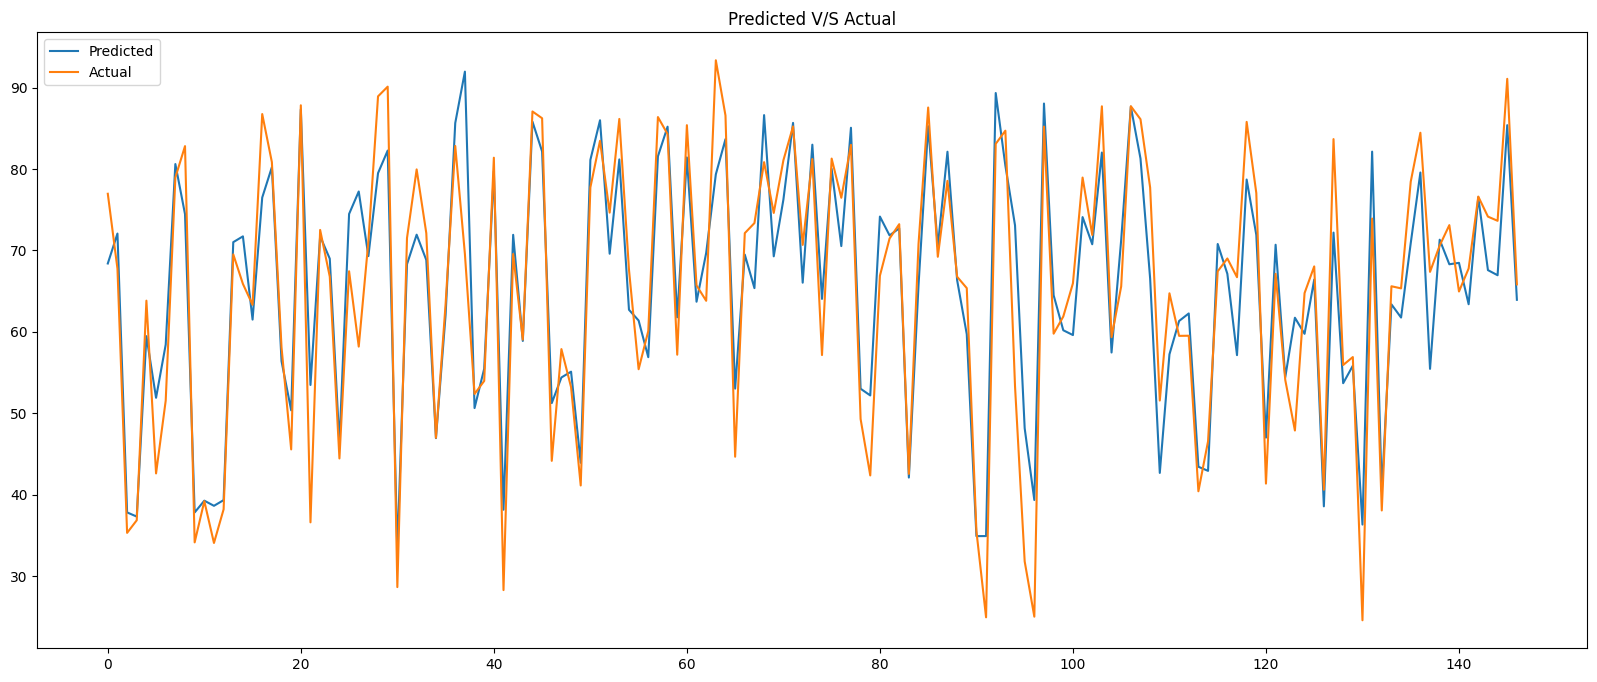

In [64]:
plot_Pred_vs_actual(y_pred,y_test)

Text(0.5, 0, 'y_predicted')

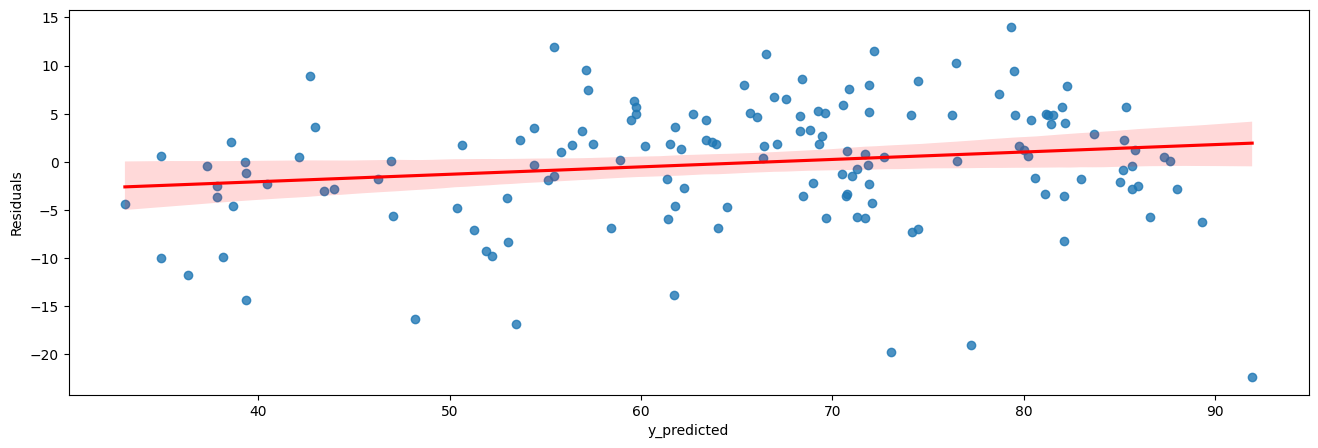

In [65]:
# Check Homoscedasticity by plotting y_predicted values and the residuals
plt.figure(figsize=(16,5))
sns.regplot(x = y_pred, y = y_test-y_pred,line_kws={'color':'red'})
plt.ylabel('Residuals')
plt.xlabel('y_predicted')

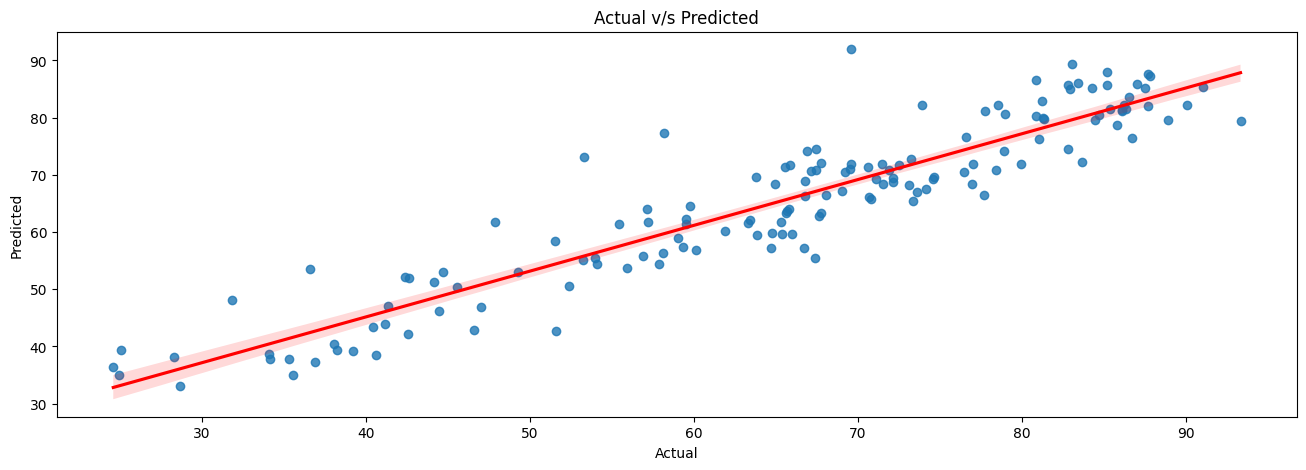

In [66]:
# Checking how predicted values and actual values are close  to the regression line
plot_scatter(y_pred,y_test)

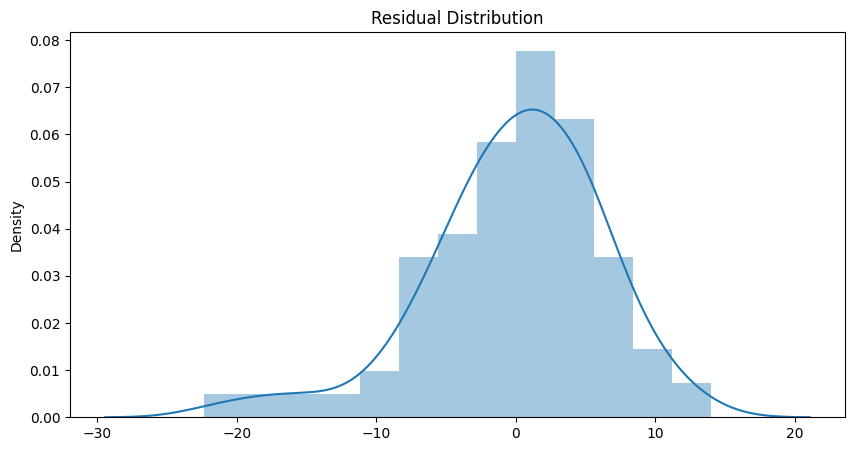

In [67]:
Residual_distPlot(y_pred,y_test)

The residuals form a near-normal distribution centered around zero, which indicates that the Linear Regression model is performing well — the errors are random, balanced, and not biased in any particular direction.

#### GENERAL INSIGHTS - plots after model evaluation

What are residuals?

Residuals = (Actual value − Predicted value)

They represent how far off your model’s predictions are for each data point.

If residual = 0 → perfect prediction

Negative residual → model overpredicted

Positive residual → model underpredicted